In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import json
import torch
import lm_eval
from transformers import AutoModelForCausalLM, AutoTokenizer, AutoConfig
from typing import Tuple, List
import einops
from tqdm import tqdm
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
os.chdir("..")

In [4]:
from model import CustomLlamaConfig, CustomLLaMA
from model_api import CustomModelHandler, prepare_for_formatting, load_config, format_model_input, load_config, format_prompt, texts_to_prepared_ids
from model_api import load_config, format_prompt

[2025-02-10 15:29:01,312] [INFO] [real_accelerator.py:222:get_accelerator] Setting ds_accelerator to cuda (auto detect)


2025-02-10:15:29:01,400 INFO     [spawn.py:60] /nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/bin/x86_64-conda-linux-gnu-cc -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/include -I/nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/targets/x86_64-linux/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/include -I/nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/targets/x86_64-linux/include -fPIC -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/include -I/nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/targets/x86_64-linux/include -c /tmp/tmpvzn_h5x1/test.c -o /tmp/tmpvzn_h5x1/test.o
2025-02-10:15:29:01,424 INFO     [spawn.py:60] /nfs/scistore23/chlgrp/ekortuko/mini

/nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/bin/../lib/gcc/x86_64-conda-linux-gnu/13.3.0/../../../../x86_64-conda-linux-gnu/bin/ld: cannot find -laio: No such file or directory
collect2: error: ld returned 1 exit status
2025-02-10:15:29:01,946 INFO     [spawn.py:60] /nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/bin/x86_64-conda-linux-gnu-cc -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/include -I/nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/targets/x86_64-linux/include -DNDEBUG -D_FORTIFY_SOURCE=2 -O2 -isystem /nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/include -I/nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/targets/x86_64-linux/include -fPIC -march=nocona -mtune=haswell -ftree-vectorize -fPIC -fstack-protector-strong -fno-plt -O2 -ffunction-sections -pipe -isystem /nfs/scistore23/chlgrp/ekortuko/miniforge3/envs/side/

In [5]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"

# Gather last token activations

## Load the model

Double model with rotation.

In [6]:
# AutoConfig.register("custom_llama", CustomLlamaConfig)
# AutoModelForCausalLM.register(CustomLlamaConfig, CustomLLaMA)

# model_name = "Embeddings-Collab/llama_3.1_8b_double_emb_SFTv50_from_base_run_5e-6_bs8"
# # model_name = "models/Embeddings-Collab/llama_3.2_3b_double_emb_SFTv31_run_2"
# embedding_type = "double_emb"
# base_model ="meta-llama/Llama-3.1-8B"
# handler = CustomModelHandler(model_name, base_model, base_model, model_name, None,
#                                 0, embedding_type=embedding_type,
#                                 load_from_checkpoint=True,
#                                 model_dtype=torch.float16
#                                 )

# system_prompt_len = 56
# template_infix_len = 7
# template_suffix_len = 5 


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Finished tokenizer init. len(tokenizer) = 128256, tokenizer.vocab_size = 128000
None


Double model without rotation.

In [7]:
AutoConfig.register("custom_llama", CustomLlamaConfig)
AutoModelForCausalLM.register(CustomLlamaConfig, CustomLLaMA)

model_name = "Embeddings-Collab/llama_3.1_8b_double_emb_SFTv50_from_base_run_5e-6_bs8_norotation"
embedding_type = "double_emb"
base_model ="meta-llama/Llama-3.1-8B"
handler = CustomModelHandler(model_name, base_model, base_model, model_name, None,
                                0, embedding_type=embedding_type,
                                load_from_checkpoint=True,
                                model_dtype=torch.float16
                                )

system_prompt_len = 56
template_infix_len = 7
template_suffix_len = 5 


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


Finished tokenizer init. len(tokenizer) = 128256, tokenizer.vocab_size = 128000


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


None


In [8]:
handler.model.to(device)

CustomLLaMA(
  (model): LlamaModel(
    (embed_tokens): Embedding(256256, 4096, padding_idx=128011)
    (layers): ModuleList(
      (0-31): 32 x LlamaDecoderLayer(
        (self_attn): LlamaAttention(
          (q_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): LlamaMLP(
          (gate_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): LlamaRMSNorm((4096,), eps=1e-05)
      )
 

## Load the data

We use 100 examples from the SEP dataset.
We also take keys "system_prompt_clean" and "prompt_instructed" to get the case where probe is in data.

In [11]:
# Get our custom chat template.
with open("data/prompt_templates.json", "r") as f:
        templates = json.load(f)
template = templates[0]

In [12]:
subset_length = 100

full_sep_path = "data/SEP_dataset_1k.json"
with open(full_sep_path, "r") as f:
    full_sep_data = json.load(f)


data = full_sep_data[:subset_length]
dataset_name = "SEP_first100"


In [13]:
template

{'system': 'Below is an instruction that describes a task, paired with an input that provides further context.\nWrite a response that appropriately completes the request.\n\nInstruction:\n{}\n',
 'user': 'Input:\n{}\n',
 'output': 'Response: {} End Of Response.\n\n'}

In [14]:
instruction_text = "Solve the following math problem."
data_text = "What is 2 + 2? Who is Einstein?"


instruction_prompt = format_prompt(instruction_text, template, "system")
data_prompt = format_prompt(data_text, template, "user")
output, inst_tokens, data_tokens, inst_hidden, data_hidden, last_hidden, inp = handler.generate_one_token_with_hidden_states(
        instruction_prompt, data_prompt, system_prompt_len=system_prompt_len, template_infix_len=template_infix_len, template_suffix_len=template_suffix_len,
)

print("IIII:", inp)
print(f"INST tokens: {inst_tokens}")
print(f"DATA tokens: {data_tokens}")
print("RRRR:", output)

From v4.47 onwards, when a model cache is to be returned, `generate` will return a `Cache` instance instead by default (as opposed to the legacy tuple of tuples format). If you want to keep returning the legacy format, please set `return_legacy_cache=True`.


IIII: [('<|begin_of_text|><|start_header_id|>system<|end_header_id|>\n\nCutting Knowledge Date: December 2023\nToday Date: 26 Jul 2024\n\nBelow is an instruction that describes a task, paired with an input that provides further context.\nWrite a response that appropriately completes the request.\n\nInstruction:\nSolve the following math problem.<|eot_id|><|start_header_id|>user<|end_header_id|>\n\n', 'inst'), ('Input:\nWhat is 2 + 2? Who is Einstein?<|eot_id|><|start_header_id|>assistant<|end_header_id|>\n\n', 'data')]
INST tokens: ['S', 'olve', 'Ġthe', 'Ġfollowing', 'Ġmath', 'Ġproblem', '.']
DATA tokens: ['What', 'Ġis', 'Ġ', '2', 'Ġ+', 'Ġ', '2', '?', 'ĠWho', 'Ġis', 'ĠEinstein', '?']
RRRR: Response


In [15]:
# This is 
# Gather inst and data hidden states into one big tensor for all examples in the SEP dataset
last_activations = []

# Numbers for template used with SFTv40. Beware, this will break when we change tokenization again.
system_prompt_len = 56
template_infix_len = 7
template_suffix_len = 5 

for example in tqdm(data):
    instruction_text = example["system_prompt_clean"]
    data_text = example["prompt_instructed"]

    instruction_prompt = format_prompt(instruction_text, template, "system")
    data_prompt = format_prompt(data_text, template, "user")

    output, inst_tokens, data_tokens, inst_hidden, data_hidden, last_hidden, inp = handler.generate_one_token_with_hidden_states(
        instruction_prompt, data_prompt, system_prompt_len=system_prompt_len, template_infix_len=template_infix_len, template_suffix_len=template_suffix_len,
    )

    last_activations.append(last_hidden)

last_hidden_all = torch.stack(last_activations, dim=0)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:05<00:00, 17.51it/s]


In [16]:
short_model_name = model_name.split("/")[-1]
hidden_states_save_dir = f"interp/last_acts/{dataset_name}/{short_model_name}"
os.makedirs(hidden_states_save_dir, exist_ok=True)
last_save_path = f"{hidden_states_save_dir}/last_hidden_states.pt"

torch.save(last_hidden_all, last_save_path)

# Load activations and compute metrics

## Load activations

In [17]:
acts_dir = "interp/last_acts/SEP_first100"
double_model_short_name = "llama_3.1_8b_double_emb_SFTv50_from_base_run_5e-6_bs8"
no_rot_model_short_name = "llama_3.1_8b_double_emb_SFTv50_from_base_run_5e-6_bs8_norotation"

double_model_path = f"{acts_dir}/{double_model_short_name}/last_hidden_states.pt"
no_rot_model_path = f"{acts_dir}/{no_rot_model_short_name}/last_hidden_states.pt"

double_model_acts = torch.load(double_model_path).to("cpu")
no_rot_model_acts = torch.load(no_rot_model_path).to("cpu")

/tmp/ipykernel_668392/1854582963.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  double_model_acts = torch.load(double_model_path).to("cpu")
/tmp/ipykernel_668392/185458

## Compute cosine similarities

In [18]:
double_model_acts.shape, no_rot_model_acts.shape

(torch.Size([100, 33, 4096]), torch.Size([100, 33, 4096]))

In [19]:
per_example_cosine_similarities = torch.nn.functional.cosine_similarity(double_model_acts, no_rot_model_acts, dim=-1)

avg_per_layer_cosine_similarities = per_example_cosine_similarities.mean(dim=0)
std_per_layer_cosine_similarities = per_example_cosine_similarities.std(dim=0)

assert avg_per_layer_cosine_similarities.shape == (33,)

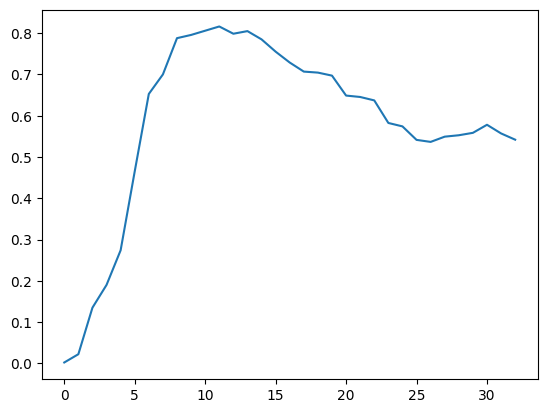

In [20]:
plt.plot(avg_per_layer_cosine_similarities)

## Plot cosine similarities

2025-02-10:15:55:18,142 INFO     [__init__.py:3337] maxp pruned
2025-02-10:15:55:18,145 INFO     [__init__.py:3337] cmap pruned
2025-02-10:15:55:18,146 INFO     [__init__.py:3337] post pruned
2025-02-10:15:55:18,147 INFO     [__init__.py:3337] CFF  pruned
2025-02-10:15:55:18,147 INFO     [__init__.py:3321] PCLT dropped
2025-02-10:15:55:18,148 INFO     [__init__.py:3337] GPOS pruned
2025-02-10:15:55:18,151 INFO     [__init__.py:3337] GSUB pruned
2025-02-10:15:55:18,151 INFO     [__init__.py:3380] Added .notdef to subset
2025-02-10:15:55:18,152 INFO     [__init__.py:3403] Closing glyph list over 'GSUB': 31 glyphs before
2025-02-10:15:55:18,152 INFO     [__init__.py:457] Glyph names: ['.notdef', 'A', 'C', 'D', 'E', 'I', 'L', 'S', 'a', 'e', 'eight', 'four', 'hyphen', 'i', 'l', 'm', 'n', 'o', 'one', 'p', 'period', 'r', 's', 'six', 'space', 't', 'three', 'two', 'v', 'y', 'zero']
2025-02-10:15:55:18,153 INFO     [__init__.py:460] Glyph IDs:   [0, 1, 14, 15, 17, 18, 19, 20, 21, 23, 25, 34, 36,

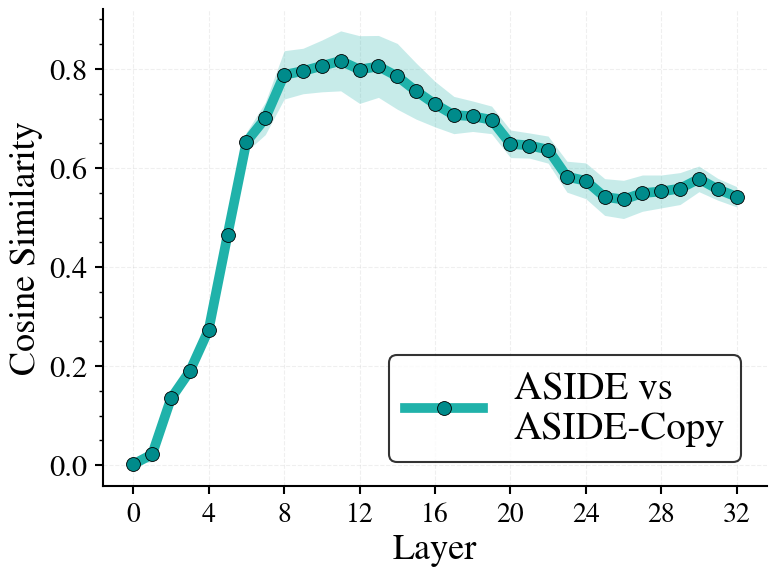

In [22]:
# Set the style
# plt.style.use('seaborn-paper')
plt.style.use('seaborn-v0_8-paper')
sns.set_context("paper", font_scale=1.5)
plt.rcParams['font.family'] = ['serif']
plt.rcParams['font.serif'] = ['Nimbus Roman']
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42  # Ensure text is editable in PDF


# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Color palette that's colorblind-friendly
colors = ['blue', "orange", "green"]

palette = sns.color_palette("tab10")
colors = palette[0:3]


color1 = "lightseagreen"
color2 = "darkcyan"

# How to use this ?
# std_per_layer_cosine_similarities

# Before your current plot line, add this:
ax.fill_between(range(33), 
                avg_per_layer_cosine_similarities - std_per_layer_cosine_similarities,
                avg_per_layer_cosine_similarities + std_per_layer_cosine_similarities,
                alpha=0.25,  # Controls transparency
                color=color1,  # Match the line color
                linewidth=0)

# Plot with enhanced styling
ax.plot(range(33), avg_per_layer_cosine_similarities, marker='o', label="ASIDE vs\nASIDE-Copy",

        color=color1, markersize=10, linewidth=7, markeredgewidth=0.6,
        markeredgecolor='black', markerfacecolor=color2,

        )


# Customize grid
ax.grid(True, linestyle='--', alpha=0.2)
ax.set_axisbelow(True)

# Customize spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.5)
ax.spines['bottom'].set_linewidth(1.5)

# Labels and title
ax.set_xlabel('Layer', fontsize=26)
ax.set_ylabel('Cosine Similarity', fontsize=26)
# ax.set_ylim(0.58, 1.05)

# Customize ticks
ax.tick_params(axis='both', which='major', labelsize=12, width=1.5, length=6)
ax.tick_params(axis='both', which='minor', width=1, length=3)

# Customize x and y axis tick font
plt.xticks(fontsize=20)
plt.yticks(fontsize=22)

# Add the last layer to the x-axis
ax.set_xticks(np.arange(0, 33, 4))

# Add minor ticks
ax.yaxis.set_minor_locator(plt.MultipleLocator(0.05))

# Legend
legend = ax.legend(frameon=True, loc='lower right', 
                 bbox_to_anchor=(0.99, 0.01),
                  fontsize=28)
legend.get_frame().set_linewidth(1.5)
legend.get_frame().set_edgecolor('black')

# Adjust layout
plt.tight_layout()
# plt.show()

# Save with high DPI
plt.savefig('4_2_rotation_downstream.pdf', dpi=300, bbox_inches='tight')
plt.show()